## Imports

In [1]:
# !pip install torchtext==0.6.0

In [2]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [3]:
batch_size = 16
max_length = 82
vocab_size = 3097

PATH = "path"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [4]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [5]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [6]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

.vector_cache/glove.6B.zip: 862MB [02:44, 5.23MB/s]                           
100%|█████████▉| 49999/50000 [00:02<00:00, 20920.65it/s]


In [7]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [8]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [9]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [10]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=3097, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [13]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        embeddings,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):

        super().__init__()

        vocab_size, d_model = embeddings.size()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [14]:
n_heads =2
num_layers = 2

In [15]:
model = Net(
    TEXT.vocab.vectors,
    nhead=n_heads,
    dim_feedforward=50,
    num_layers=num_layers,
    dropout=0.0,
    classifier_dropout=0.0,
).to(device)

In [16]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 73202


## Plot Definitions

In [17]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy[:last_epoch],label='Training',color='g')
    plt.plot(validation_accuracy[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[last_epoch],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[last_epoch],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [18]:
epochs = 200
lr = 1e-12

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 80
last_epoch = 0

WEIGHTS_PATH = "/transformer.pt"

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/200 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/200 [00:04<15:24,  4.65s/it]

Epoch: 0
Train Loss: 0.04428647987047831, Train Accuracy: 0.604
Validation Loss: 0.04640877631402785, Validation Accuracy: 0.6236559139784946
epoch=1


  1%|          | 2/200 [00:05<07:09,  2.17s/it]

Epoch: 1
Train Loss: 0.044453649759292606, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04766173901096467, Validation Accuracy: 0.6236559139784946
epoch=2


  2%|▏         | 3/200 [00:05<04:30,  1.37s/it]

Epoch: 2
Train Loss: 0.04417482860883077, Train Accuracy: 0.6213333333333333
Validation Loss: 0.04508968322507797, Validation Accuracy: 0.6236559139784946
epoch=3


  2%|▏         | 4/200 [00:05<03:16,  1.00s/it]

Epoch: 3
Train Loss: 0.04429692665735881, Train Accuracy: 0.6093333333333333
Validation Loss: 0.045029724797894875, Validation Accuracy: 0.6236559139784946
epoch=4


  2%|▎         | 5/200 [00:06<02:36,  1.24it/s]

Epoch: 4
Train Loss: 0.04438084586461385, Train Accuracy: 0.612
Validation Loss: 0.04463110816094183, Validation Accuracy: 0.6236559139784946
epoch=5


  3%|▎         | 6/200 [00:06<02:13,  1.46it/s]

Epoch: 5
Train Loss: 0.044328482151031495, Train Accuracy: 0.612
Validation Loss: 0.04509911998625724, Validation Accuracy: 0.6236559139784946
epoch=6


  4%|▎         | 7/200 [00:07<01:56,  1.66it/s]

Epoch: 6
Train Loss: 0.04424871142705281, Train Accuracy: 0.616
Validation Loss: 0.047047226659713254, Validation Accuracy: 0.6236559139784946
epoch=7


  4%|▍         | 8/200 [00:07<01:45,  1.81it/s]

Epoch: 7
Train Loss: 0.0443190233707428, Train Accuracy: 0.612
Validation Loss: 0.0445610438623736, Validation Accuracy: 0.6236559139784946
epoch=8


  4%|▍         | 9/200 [00:08<01:39,  1.92it/s]

Epoch: 8
Train Loss: 0.044437594731648766, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04559773014437768, Validation Accuracy: 0.5913978494623656
epoch=9


  5%|▌         | 10/200 [00:08<01:33,  2.03it/s]

Epoch: 9
Train Loss: 0.044362241903940836, Train Accuracy: 0.6106666666666667
Validation Loss: 0.045143461996509184, Validation Accuracy: 0.6236559139784946
epoch=10


  6%|▌         | 11/200 [00:09<01:30,  2.09it/s]

Epoch: 10
Train Loss: 0.044202342748641966, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04857384389446628, Validation Accuracy: 0.6236559139784946
epoch=11


  6%|▌         | 12/200 [00:09<01:30,  2.08it/s]

Epoch: 11
Train Loss: 0.04425704344113668, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04781699565149123, Validation Accuracy: 0.6129032258064516
epoch=12


  6%|▋         | 13/200 [00:09<01:27,  2.14it/s]

Epoch: 12
Train Loss: 0.04428560264905294, Train Accuracy: 0.6106666666666667
Validation Loss: 0.047475280300263434, Validation Accuracy: 0.6236559139784946
epoch=13


  7%|▋         | 14/200 [00:10<01:27,  2.14it/s]

Epoch: 13
Train Loss: 0.04434039974212647, Train Accuracy: 0.608
Validation Loss: 0.04463590345075054, Validation Accuracy: 0.6236559139784946
epoch=14


  8%|▊         | 15/200 [00:10<01:24,  2.19it/s]

Epoch: 14
Train Loss: 0.04420139257113139, Train Accuracy: 0.6266666666666667
Validation Loss: 0.0456501514680924, Validation Accuracy: 0.6236559139784946
epoch=15


  8%|▊         | 16/200 [00:11<01:24,  2.19it/s]

Epoch: 15
Train Loss: 0.044285588105519615, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04541756645325692, Validation Accuracy: 0.6236559139784946
epoch=16


  8%|▊         | 17/200 [00:11<01:25,  2.14it/s]

Epoch: 16
Train Loss: 0.04428818655014038, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04732020439640168, Validation Accuracy: 0.6236559139784946
epoch=17


  9%|▉         | 18/200 [00:12<01:23,  2.19it/s]

Epoch: 17
Train Loss: 0.04427646382649739, Train Accuracy: 0.612
Validation Loss: 0.04667927372840143, Validation Accuracy: 0.6236559139784946
epoch=18


 10%|▉         | 19/200 [00:12<01:20,  2.23it/s]

Epoch: 18
Train Loss: 0.04436656753222148, Train Accuracy: 0.612
Validation Loss: 0.04743945214056199, Validation Accuracy: 0.6236559139784946
epoch=19


 10%|█         | 20/200 [00:13<01:22,  2.17it/s]

Epoch: 19
Train Loss: 0.04423825248082479, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04376395671598373, Validation Accuracy: 0.6236559139784946
epoch=20


 10%|█         | 21/200 [00:13<01:21,  2.19it/s]

Epoch: 20
Train Loss: 0.044272974729537964, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04609168729474468, Validation Accuracy: 0.6236559139784946
epoch=21


 11%|█         | 22/200 [00:14<01:21,  2.18it/s]

Epoch: 21
Train Loss: 0.044299424250920615, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04489238800541047, Validation Accuracy: 0.6236559139784946
epoch=22


 12%|█▏        | 23/200 [00:14<01:20,  2.20it/s]

Epoch: 22
Train Loss: 0.044341633160909014, Train Accuracy: 0.6066666666666667
Validation Loss: 0.044325097914664977, Validation Accuracy: 0.6021505376344086
epoch=23


 12%|█▏        | 24/200 [00:14<01:19,  2.21it/s]

Epoch: 23
Train Loss: 0.044284364302953086, Train Accuracy: 0.6186666666666667
Validation Loss: 0.043968269901890907, Validation Accuracy: 0.6236559139784946
epoch=24


 12%|█▎        | 25/200 [00:15<01:20,  2.18it/s]

Epoch: 24
Train Loss: 0.04418475532531738, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04598332220508206, Validation Accuracy: 0.6236559139784946
epoch=25


 13%|█▎        | 26/200 [00:15<01:20,  2.15it/s]

Epoch: 25
Train Loss: 0.04425391459465027, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04497755727460308, Validation Accuracy: 0.6236559139784946
epoch=26


 14%|█▎        | 27/200 [00:16<01:20,  2.15it/s]

Epoch: 26
Train Loss: 0.044311285257339475, Train Accuracy: 0.612
Validation Loss: 0.045042084109398625, Validation Accuracy: 0.6236559139784946
epoch=27


 14%|█▍        | 28/200 [00:16<01:18,  2.19it/s]

Epoch: 27
Train Loss: 0.04417174371083577, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04602720660548056, Validation Accuracy: 0.6236559139784946
epoch=28


 14%|█▍        | 29/200 [00:17<01:17,  2.22it/s]

Epoch: 28
Train Loss: 0.04415575432777405, Train Accuracy: 0.608
Validation Loss: 0.043241024017333984, Validation Accuracy: 0.6129032258064516
epoch=29


 15%|█▌        | 30/200 [00:17<01:15,  2.26it/s]

Epoch: 29
Train Loss: 0.04427818767229716, Train Accuracy: 0.608
Validation Loss: 0.04527892604950936, Validation Accuracy: 0.6236559139784946
epoch=30


 16%|█▌        | 31/200 [00:18<01:18,  2.16it/s]

Epoch: 30
Train Loss: 0.04423784192403157, Train Accuracy: 0.6213333333333333
Validation Loss: 0.04524532441169985, Validation Accuracy: 0.6236559139784946
epoch=31


 16%|█▌        | 32/200 [00:18<01:18,  2.13it/s]

Epoch: 31
Train Loss: 0.04423321517308553, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04647943281358288, Validation Accuracy: 0.6129032258064516
epoch=32


 16%|█▋        | 33/200 [00:19<01:19,  2.10it/s]

Epoch: 32
Train Loss: 0.044174808502197266, Train Accuracy: 0.6213333333333333
Validation Loss: 0.04738420440304664, Validation Accuracy: 0.6236559139784946
epoch=33


 17%|█▋        | 34/200 [00:19<01:18,  2.12it/s]

Epoch: 33
Train Loss: 0.04422989050547282, Train Accuracy: 0.6186666666666667
Validation Loss: 0.0423258658378355, Validation Accuracy: 0.6236559139784946
epoch=34


 18%|█▊        | 35/200 [00:20<01:15,  2.18it/s]

Epoch: 34
Train Loss: 0.04415931455294291, Train Accuracy: 0.612
Validation Loss: 0.04496450578012774, Validation Accuracy: 0.6236559139784946
epoch=35


 18%|█▊        | 36/200 [00:20<01:07,  2.42it/s]

Epoch: 35
Train Loss: 0.04427424661318461, Train Accuracy: 0.612
Validation Loss: 0.04488052860383065, Validation Accuracy: 0.6344086021505376
epoch=36


 18%|█▊        | 37/200 [00:20<01:01,  2.67it/s]

Epoch: 36
Train Loss: 0.0442653017838796, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04597443149935815, Validation Accuracy: 0.6236559139784946
epoch=37


 19%|█▉        | 38/200 [00:20<00:56,  2.86it/s]

Epoch: 37
Train Loss: 0.044228466431299844, Train Accuracy: 0.616
Validation Loss: 0.047347853260655555, Validation Accuracy: 0.6236559139784946
epoch=38


 20%|█▉        | 39/200 [00:21<00:53,  3.02it/s]

Epoch: 38
Train Loss: 0.04427499945958455, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04494715121484572, Validation Accuracy: 0.6236559139784946
epoch=39


 20%|██        | 40/200 [00:21<00:50,  3.15it/s]

Epoch: 39
Train Loss: 0.04418211038907369, Train Accuracy: 0.616
Validation Loss: 0.044674665697159305, Validation Accuracy: 0.6344086021505376
epoch=40


 20%|██        | 41/200 [00:21<00:49,  3.22it/s]

Epoch: 40
Train Loss: 0.04441261736551921, Train Accuracy: 0.62
Validation Loss: 0.044840597337292086, Validation Accuracy: 0.6236559139784946
epoch=41


 21%|██        | 42/200 [00:22<00:48,  3.27it/s]

Epoch: 41
Train Loss: 0.04422571881612142, Train Accuracy: 0.6213333333333333
Validation Loss: 0.04491490702475271, Validation Accuracy: 0.6236559139784946
epoch=42


 22%|██▏       | 43/200 [00:22<00:47,  3.32it/s]

Epoch: 42
Train Loss: 0.04433488965034485, Train Accuracy: 0.616
Validation Loss: 0.045964917828959805, Validation Accuracy: 0.6344086021505376
epoch=43


 22%|██▏       | 44/200 [00:22<00:46,  3.33it/s]

Epoch: 43
Train Loss: 0.04423600236574809, Train Accuracy: 0.616
Validation Loss: 0.04570344186598255, Validation Accuracy: 0.6236559139784946
epoch=44


 22%|██▎       | 45/200 [00:22<00:46,  3.36it/s]

Epoch: 44
Train Loss: 0.04423424887657165, Train Accuracy: 0.6106666666666667
Validation Loss: 0.0424284242814587, Validation Accuracy: 0.6236559139784946
epoch=45


 23%|██▎       | 46/200 [00:23<00:45,  3.36it/s]

Epoch: 45
Train Loss: 0.044420459747314456, Train Accuracy: 0.616
Validation Loss: 0.04552703134475216, Validation Accuracy: 0.6236559139784946
epoch=46


 24%|██▎       | 47/200 [00:23<00:44,  3.40it/s]

Epoch: 46
Train Loss: 0.04425420967737834, Train Accuracy: 0.616
Validation Loss: 0.04523137692482241, Validation Accuracy: 0.6236559139784946
epoch=47


 24%|██▍       | 48/200 [00:23<00:44,  3.42it/s]

Epoch: 47
Train Loss: 0.04431812922159831, Train Accuracy: 0.604
Validation Loss: 0.04637554768593081, Validation Accuracy: 0.6236559139784946
epoch=48


 24%|██▍       | 49/200 [00:24<00:43,  3.45it/s]

Epoch: 48
Train Loss: 0.04430495564142863, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04519625632993637, Validation Accuracy: 0.5913978494623656
epoch=49


 25%|██▌       | 50/200 [00:24<00:43,  3.47it/s]

Epoch: 49
Train Loss: 0.044269736369450884, Train Accuracy: 0.6146666666666667
Validation Loss: 0.044741315226401054, Validation Accuracy: 0.6236559139784946
epoch=50


 26%|██▌       | 51/200 [00:24<00:42,  3.48it/s]

Epoch: 50
Train Loss: 0.04424269429842631, Train Accuracy: 0.62
Validation Loss: 0.04531525796459567, Validation Accuracy: 0.6236559139784946
epoch=51


 26%|██▌       | 52/200 [00:25<00:42,  3.45it/s]

Epoch: 51
Train Loss: 0.04426809565226237, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04548939581840269, Validation Accuracy: 0.6236559139784946
epoch=52


 26%|██▋       | 53/200 [00:25<00:42,  3.50it/s]

Epoch: 52
Train Loss: 0.04428560177485148, Train Accuracy: 0.62
Validation Loss: 0.04496146402051372, Validation Accuracy: 0.6129032258064516
epoch=53


 27%|██▋       | 54/200 [00:25<00:41,  3.53it/s]

Epoch: 53
Train Loss: 0.04428073024749756, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04432659764443674, Validation Accuracy: 0.6236559139784946
epoch=54


 28%|██▊       | 55/200 [00:25<00:41,  3.50it/s]

Epoch: 54
Train Loss: 0.04428982822100321, Train Accuracy: 0.608
Validation Loss: 0.04655618821420977, Validation Accuracy: 0.6236559139784946
epoch=55


 28%|██▊       | 56/200 [00:26<00:40,  3.55it/s]

Epoch: 55
Train Loss: 0.04435606813430786, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04456466628659156, Validation Accuracy: 0.6236559139784946
epoch=56


 28%|██▊       | 57/200 [00:26<00:40,  3.56it/s]

Epoch: 56
Train Loss: 0.04416644525527954, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04625120086054648, Validation Accuracy: 0.6236559139784946
epoch=57


 29%|██▉       | 58/200 [00:26<00:39,  3.57it/s]

Epoch: 57
Train Loss: 0.04433245086669922, Train Accuracy: 0.604
Validation Loss: 0.04571317857311618, Validation Accuracy: 0.6236559139784946
epoch=58


 30%|██▉       | 59/200 [00:26<00:39,  3.55it/s]

Epoch: 58
Train Loss: 0.04430542405446371, Train Accuracy: 0.612
Validation Loss: 0.04582929226659959, Validation Accuracy: 0.6236559139784946
epoch=59


 30%|███       | 60/200 [00:27<00:39,  3.57it/s]

Epoch: 59
Train Loss: 0.04441157563527425, Train Accuracy: 0.6053333333333333
Validation Loss: 0.04629179739182995, Validation Accuracy: 0.6236559139784946
epoch=60


 30%|███       | 61/200 [00:27<00:39,  3.54it/s]

Epoch: 60
Train Loss: 0.0442558175722758, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04512186204233477, Validation Accuracy: 0.6236559139784946
epoch=61


 31%|███       | 62/200 [00:27<00:38,  3.56it/s]

Epoch: 61
Train Loss: 0.04421814854939778, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04427255738166071, Validation Accuracy: 0.6236559139784946
epoch=62


 32%|███▏      | 63/200 [00:28<00:38,  3.54it/s]

Epoch: 62
Train Loss: 0.04426783633232117, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04586967345206968, Validation Accuracy: 0.6236559139784946
epoch=63


 32%|███▏      | 64/200 [00:28<00:38,  3.53it/s]

Epoch: 63
Train Loss: 0.04421501080195109, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04407361630470522, Validation Accuracy: 0.6236559139784946
epoch=64


 32%|███▎      | 65/200 [00:28<00:38,  3.54it/s]

Epoch: 64
Train Loss: 0.04422314929962158, Train Accuracy: 0.608
Validation Loss: 0.045216591127457156, Validation Accuracy: 0.6236559139784946
epoch=65


 33%|███▎      | 66/200 [00:28<00:39,  3.41it/s]

Epoch: 65
Train Loss: 0.04430068310101827, Train Accuracy: 0.6213333333333333
Validation Loss: 0.04586809681307885, Validation Accuracy: 0.6236559139784946
epoch=66


 34%|███▎      | 67/200 [00:29<00:39,  3.37it/s]

Epoch: 66
Train Loss: 0.04420917320251465, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04701713208229311, Validation Accuracy: 0.6236559139784946
epoch=67


 34%|███▍      | 68/200 [00:29<00:38,  3.40it/s]

Epoch: 67
Train Loss: 0.04432085418701172, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04533059750833819, Validation Accuracy: 0.6129032258064516
epoch=68


 34%|███▍      | 69/200 [00:29<00:40,  3.23it/s]

Epoch: 68
Train Loss: 0.04436281458536784, Train Accuracy: 0.6186666666666667
Validation Loss: 0.045033770222817696, Validation Accuracy: 0.6236559139784946
epoch=69


 35%|███▌      | 70/200 [00:30<00:44,  2.92it/s]

Epoch: 69
Train Loss: 0.0442827935218811, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04526481320781092, Validation Accuracy: 0.6236559139784946
epoch=70


 36%|███▌      | 71/200 [00:30<00:46,  2.78it/s]

Epoch: 70
Train Loss: 0.04424205946922302, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04568346854179136, Validation Accuracy: 0.6236559139784946
epoch=71


 36%|███▌      | 72/200 [00:31<00:47,  2.68it/s]

Epoch: 71
Train Loss: 0.04434158937136332, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04541297112741778, Validation Accuracy: 0.6236559139784946
epoch=72


 36%|███▋      | 73/200 [00:31<00:48,  2.61it/s]

Epoch: 72
Train Loss: 0.04432582783699036, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04622239451254568, Validation Accuracy: 0.6129032258064516
epoch=73


 37%|███▋      | 74/200 [00:31<00:48,  2.57it/s]

Epoch: 73
Train Loss: 0.04433637841542562, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04501601957505749, Validation Accuracy: 0.6129032258064516
epoch=74


 38%|███▊      | 75/200 [00:32<00:49,  2.52it/s]

Epoch: 74
Train Loss: 0.04426161662737529, Train Accuracy: 0.612
Validation Loss: 0.04560422897338867, Validation Accuracy: 0.6129032258064516
epoch=75


 38%|███▊      | 76/200 [00:32<00:49,  2.51it/s]

Epoch: 75
Train Loss: 0.04437571859359741, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04445514755864297, Validation Accuracy: 0.6129032258064516
epoch=76


 38%|███▊      | 77/200 [00:33<00:49,  2.51it/s]

Epoch: 76
Train Loss: 0.0442536826133728, Train Accuracy: 0.62
Validation Loss: 0.04483336017977807, Validation Accuracy: 0.6236559139784946
epoch=77


 39%|███▉      | 78/200 [00:33<00:48,  2.53it/s]

Epoch: 77
Train Loss: 0.04424215229352315, Train Accuracy: 0.616
Validation Loss: 0.0471377142014042, Validation Accuracy: 0.6236559139784946
epoch=78


 40%|███▉      | 79/200 [00:33<00:48,  2.51it/s]

Epoch: 78
Train Loss: 0.04420140687624614, Train Accuracy: 0.612
Validation Loss: 0.04648201311788251, Validation Accuracy: 0.6129032258064516
epoch=79


 40%|████      | 80/200 [00:34<00:47,  2.52it/s]

Epoch: 79
Train Loss: 0.044260066668192544, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04466177571204401, Validation Accuracy: 0.6236559139784946
epoch=80


 40%|████      | 81/200 [00:34<00:46,  2.54it/s]

Epoch: 80
Train Loss: 0.044331232229868574, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04548586953070856, Validation Accuracy: 0.6236559139784946
epoch=81


 41%|████      | 82/200 [00:35<00:47,  2.50it/s]

Epoch: 81
Train Loss: 0.044230960210164386, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04643297579980666, Validation Accuracy: 0.6236559139784946
epoch=82


 42%|████▏     | 83/200 [00:35<00:44,  2.62it/s]

Epoch: 82
Train Loss: 0.04434324185053507, Train Accuracy: 0.616
Validation Loss: 0.046040688791582664, Validation Accuracy: 0.6236559139784946
epoch=83


 42%|████▏     | 84/200 [00:35<00:40,  2.85it/s]

Epoch: 83
Train Loss: 0.04431919550895691, Train Accuracy: 0.62
Validation Loss: 0.04474577980656778, Validation Accuracy: 0.6236559139784946
epoch=84


 42%|████▎     | 85/200 [00:36<00:38,  3.01it/s]

Epoch: 84
Train Loss: 0.04435025715827942, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04503237047503071, Validation Accuracy: 0.6236559139784946
epoch=85


 43%|████▎     | 86/200 [00:36<00:36,  3.10it/s]

Epoch: 85
Train Loss: 0.04422249015172323, Train Accuracy: 0.6213333333333333
Validation Loss: 0.046410983608615015, Validation Accuracy: 0.6236559139784946
epoch=86


 44%|████▎     | 87/200 [00:36<00:35,  3.19it/s]

Epoch: 86
Train Loss: 0.044156458616256715, Train Accuracy: 0.6253333333333333
Validation Loss: 0.04543348281614242, Validation Accuracy: 0.6236559139784946
epoch=87


 44%|████▍     | 88/200 [00:36<00:34,  3.28it/s]

Epoch: 87
Train Loss: 0.04439463559786479, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04633973490807318, Validation Accuracy: 0.6236559139784946
epoch=88


 44%|████▍     | 89/200 [00:37<00:33,  3.35it/s]

Epoch: 88
Train Loss: 0.04438642406463623, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04525438431770571, Validation Accuracy: 0.6236559139784946
epoch=89


 45%|████▌     | 90/200 [00:37<00:32,  3.42it/s]

Epoch: 89
Train Loss: 0.04425359718004863, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04561882249770626, Validation Accuracy: 0.6236559139784946
epoch=90


 46%|████▌     | 91/200 [00:37<00:31,  3.43it/s]

Epoch: 90
Train Loss: 0.04425689800580342, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04577259863576581, Validation Accuracy: 0.6236559139784946
epoch=91


 46%|████▌     | 92/200 [00:38<00:31,  3.41it/s]

Epoch: 91
Train Loss: 0.044127904335657754, Train Accuracy: 0.616
Validation Loss: 0.04454600811004639, Validation Accuracy: 0.6236559139784946
epoch=92


 46%|████▋     | 93/200 [00:38<00:31,  3.39it/s]

Epoch: 92
Train Loss: 0.0443127969900767, Train Accuracy: 0.6173333333333333
Validation Loss: 0.046800286539139285, Validation Accuracy: 0.6236559139784946
epoch=93


 47%|████▋     | 94/200 [00:38<00:31,  3.40it/s]

Epoch: 93
Train Loss: 0.04415558807055155, Train Accuracy: 0.608
Validation Loss: 0.04550855005941083, Validation Accuracy: 0.6236559139784946
epoch=94


 48%|████▊     | 95/200 [00:38<00:30,  3.43it/s]

Epoch: 94
Train Loss: 0.044173487504323324, Train Accuracy: 0.6066666666666667
Validation Loss: 0.044589308000379996, Validation Accuracy: 0.6236559139784946
epoch=95


 48%|████▊     | 96/200 [00:39<00:30,  3.43it/s]

Epoch: 95
Train Loss: 0.04418969432512919, Train Accuracy: 0.616
Validation Loss: 0.04516080117994739, Validation Accuracy: 0.6021505376344086
epoch=96


 48%|████▊     | 97/200 [00:39<00:29,  3.45it/s]

Epoch: 96
Train Loss: 0.044236748298009235, Train Accuracy: 0.616
Validation Loss: 0.04622768586681735, Validation Accuracy: 0.6129032258064516
epoch=97


 49%|████▉     | 98/200 [00:39<00:29,  3.46it/s]

Epoch: 97
Train Loss: 0.04420753757158915, Train Accuracy: 0.6146666666666667
Validation Loss: 0.045047821537140875, Validation Accuracy: 0.6236559139784946
epoch=98


 50%|████▉     | 99/200 [00:40<00:29,  3.48it/s]

Epoch: 98
Train Loss: 0.044163342793782555, Train Accuracy: 0.612
Validation Loss: 0.04431643793659826, Validation Accuracy: 0.6021505376344086
epoch=99


 50%|█████     | 100/200 [00:40<00:28,  3.49it/s]

Epoch: 99
Train Loss: 0.044110427141189575, Train Accuracy: 0.612
Validation Loss: 0.04424837327772571, Validation Accuracy: 0.6236559139784946
epoch=100


 50%|█████     | 101/200 [00:40<00:28,  3.52it/s]

Epoch: 100
Train Loss: 0.04438578160603841, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04686562092073502, Validation Accuracy: 0.6129032258064516
epoch=101


 51%|█████     | 102/200 [00:40<00:27,  3.52it/s]

Epoch: 101
Train Loss: 0.04423166608810425, Train Accuracy: 0.608
Validation Loss: 0.047279504037672476, Validation Accuracy: 0.6236559139784946
epoch=102


 52%|█████▏    | 103/200 [00:41<00:27,  3.52it/s]

Epoch: 102
Train Loss: 0.04435181967417399, Train Accuracy: 0.604
Validation Loss: 0.04578848038950274, Validation Accuracy: 0.6236559139784946
epoch=103


 52%|█████▏    | 104/200 [00:41<00:27,  3.54it/s]

Epoch: 103
Train Loss: 0.04422106258074442, Train Accuracy: 0.612
Validation Loss: 0.045730340865350536, Validation Accuracy: 0.6236559139784946
epoch=104


 52%|█████▎    | 105/200 [00:41<00:26,  3.52it/s]

Epoch: 104
Train Loss: 0.04432749565442403, Train Accuracy: 0.604
Validation Loss: 0.04627453896307176, Validation Accuracy: 0.6129032258064516
epoch=105


 53%|█████▎    | 106/200 [00:42<00:26,  3.52it/s]

Epoch: 105
Train Loss: 0.04425232068697611, Train Accuracy: 0.616
Validation Loss: 0.044807603282313195, Validation Accuracy: 0.6236559139784946
epoch=106


 54%|█████▎    | 107/200 [00:42<00:26,  3.48it/s]

Epoch: 106
Train Loss: 0.044195348262786864, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04604860275022445, Validation Accuracy: 0.6236559139784946
epoch=107


 54%|█████▍    | 108/200 [00:42<00:26,  3.48it/s]

Epoch: 107
Train Loss: 0.04426153834660848, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04491270742108745, Validation Accuracy: 0.6236559139784946
epoch=108


 55%|█████▍    | 109/200 [00:42<00:26,  3.49it/s]

Epoch: 108
Train Loss: 0.044281037330627444, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04467054336301742, Validation Accuracy: 0.6236559139784946
epoch=109


 55%|█████▌    | 110/200 [00:43<00:25,  3.48it/s]

Epoch: 109
Train Loss: 0.044290335257848104, Train Accuracy: 0.6093333333333333
Validation Loss: 0.044061614621070125, Validation Accuracy: 0.6236559139784946
epoch=110


 56%|█████▌    | 111/200 [00:43<00:25,  3.47it/s]

Epoch: 110
Train Loss: 0.044106945037841794, Train Accuracy: 0.62
Validation Loss: 0.045982814604236234, Validation Accuracy: 0.6236559139784946
epoch=111


 56%|█████▌    | 112/200 [00:43<00:25,  3.44it/s]

Epoch: 111
Train Loss: 0.0441836953163147, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04585224582302955, Validation Accuracy: 0.6236559139784946
epoch=112


 56%|█████▋    | 113/200 [00:44<00:25,  3.46it/s]

Epoch: 112
Train Loss: 0.044344106038411456, Train Accuracy: 0.6146666666666667
Validation Loss: 0.048110869622999625, Validation Accuracy: 0.6236559139784946
epoch=113


 57%|█████▋    | 114/200 [00:44<00:24,  3.45it/s]

Epoch: 113
Train Loss: 0.04411999686559041, Train Accuracy: 0.616
Validation Loss: 0.043957302647252235, Validation Accuracy: 0.6236559139784946
epoch=114


 57%|█████▊    | 115/200 [00:44<00:24,  3.50it/s]

Epoch: 114
Train Loss: 0.0441960236231486, Train Accuracy: 0.6133333333333333
Validation Loss: 0.0452282351832236, Validation Accuracy: 0.6236559139784946
epoch=115


 58%|█████▊    | 116/200 [00:44<00:23,  3.52it/s]

Epoch: 115
Train Loss: 0.04426098012924194, Train Accuracy: 0.6013333333333334
Validation Loss: 0.046895926998507594, Validation Accuracy: 0.6236559139784946
epoch=116


 58%|█████▊    | 116/200 [00:45<00:32,  2.56it/s]


## Testing

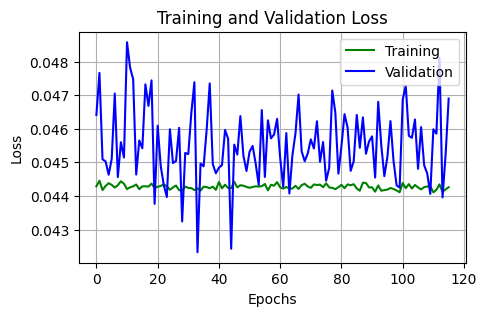

Final Training Loss:   0.044128
Final Validation Loss: 0.014984


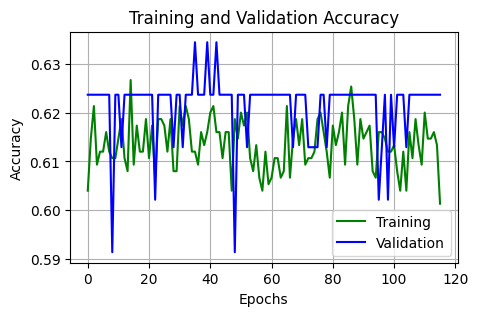

Final Training Accuracy:   0.617333
Final Validation Accuracy: 0.634409

Test Accuracy: 0.6146



In [20]:
num_correct_test = 0
evalModel = Net(
    TEXT.vocab.vectors,
    nhead=n_heads,
    dim_feedforward=50,
    num_layers=num_layers,
    dropout=0.0,
    classifier_dropout=0.0,
).to(device)
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)